## Деревья решений для задач классификации

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Загружаем данные о выдаче кредита.  
- кредит -- решение о выдаче кредита (низкий или высокий),
- класс -- класс профессии (упорядоченный с точки зрения платёжеспособности),
- з\_плата -- способ выдачи зарплаты (ежемесячно или еженедельно),
- возраст -- разбитый по сегментам,
- кр\_карта -- есть или нет кредитная карта.

In [2]:
df = pd.read_csv('Credit.csv', sep=';', encoding='cp1251')

In [3]:
df.head()

,кредит,клаcс,з_плата,возраст,кр_карта
0,1,2,2,2,1
1,0,2,1,2,0
2,0,4,1,1,1
3,1,2,2,2,0
4,1,3,2,1,0


In [4]:
# Правильный ответ записываем в вектор y
y = df[u'кредит']
# Удаляем колонку с правильным ответом
X = df.drop(u'кредит', axis=1)

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Инициализируем модель
model = DecisionTreeClassifier(random_state=42,
                               # функция для impurity ('gini' или 'entropy')
                               criterion='gini',
                               # максимальная глубина дерева
                               max_depth=50,
                               # минимальное число элементов в узле для разбиения (может быть долей)
                               min_samples_split=3,
                               # минимальное число элементов в листе (может быть долей)
                               min_samples_leaf=3,
                               # минимальное значение дельты impurity
                               # min_impurity_decrease=0,
                               # веса для классов (можно дополнительно штрафовать за ошибку в нужных классах).
                               # поддерживает опцию 'balanced'.
                               class_weight=None,
                               )

# Обучаем модель
model.fit(X, y)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3,
                       random_state=42)

Для интерпретации получившейся модели удобно изобразить её в виде дерева предикатов (решающих правил). Для этого в ```sklearn.tree``` предусмотрена функция ```export_graphviz```. Однако неудобство её в том, что она выдаёт результат в виде файла векторной графики ```.dot```, который нужно дополнительно преобразовать в привычный формат (например, в ```.png```).

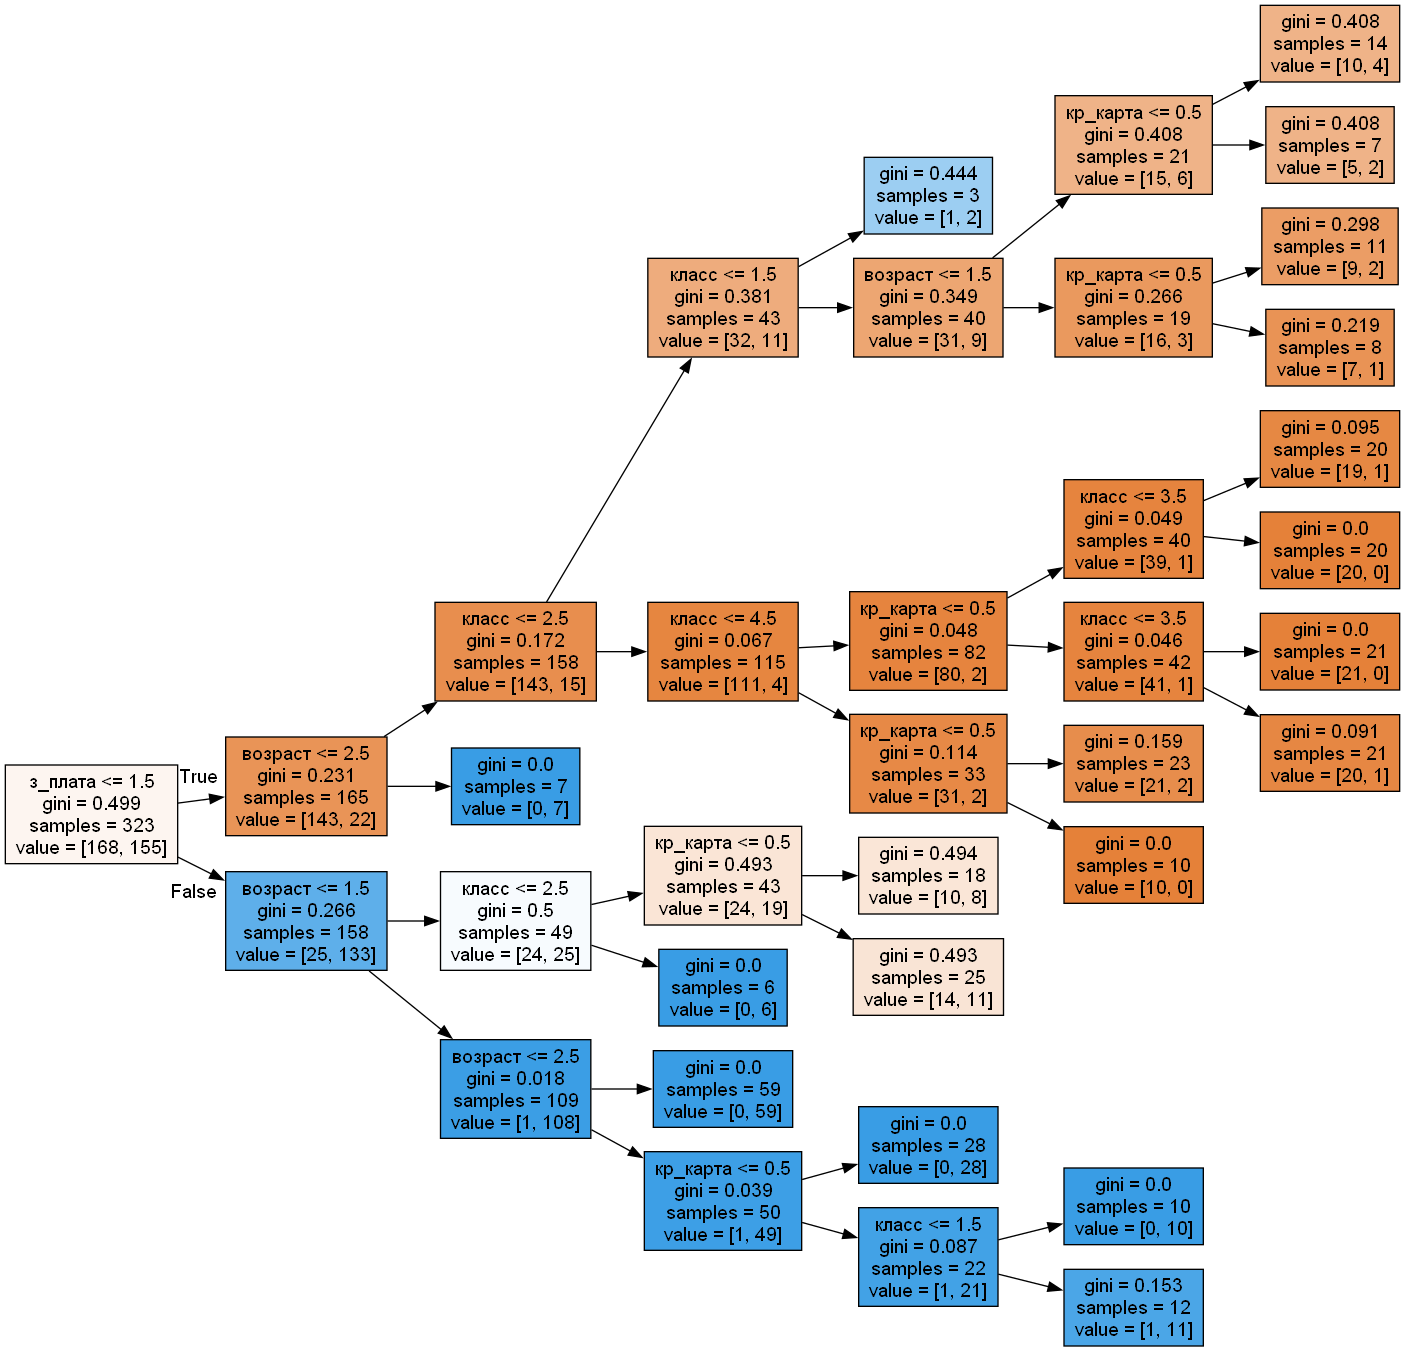

In [6]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

export_graphviz(model,
                out_file='tree.dot',
                # задать названия фич
                feature_names=X.columns,
                class_names=None,
                # показывать названия полей у численных значений внутри узла
                label='all',
                # раскрашивать узлы в цвет преобладающего класса
                filled=True,
                # показывать значение impurity для каждого узла
                impurity=True,
                # показывать номера узлов
                node_ids=False,
                # Показывать доли каждого класса в узлах (а не количество)
                proportion=False,
                # Повернуть дерево на 90 градусов (вертикальная ориентация)
                rotate=True,
                # Число точек после запятой для отображаемых дробей
                #precision=3
               )
# Преобразуем файл tree.dot в tree.png
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png']);
# Вставляем картинку в блокнот
Image("tree.png")

In [7]:
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,з_плата,0.699553
2,возраст,0.232672
0,клаcс,0.066163
3,кр_карта,0.001612


Модель позволяет оценить ценность каждой фичи в смысле её эффективности для разбиения (Gini importance). Эта оценка считает для каждой из фич сумму дельт по impurity (нормированную), полученных при разбиениях по этой фиче. Для этого у модели есть метод ```feature_importances_```.

Как и ранее, у данной модели реализован метод ```predict```, который позволяет получить предсказания классов для входного списка элементов, представленных в пространстве тех же самых признаков (то есть подаём на вход матрицу).

In [8]:
# Предсказание класса для новых элементов
new_item = [1, 1, 1, 1]
model.predict([new_item])

C:\Users\Evgen\NeuralNetworks\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

## Разбиение на обучающую и тестовую выборку

Данную модель мы обучили на всех имеющихся данных. С одной стороны это хорошо -- ведь мы использовали все имеющиеся данные, с другой стороны, это плохо с точки зрения оценки качества получившейся модели. Хорошо бы уметь его измерять. Оценка качества поможет нам улучшать текущую модель и сравнивать результаты с другими моделями. Хочется, чтобы у нас была отдельная тестовая выборка, на которой можно было бы проверять качество полученной модели. Ведь если взять любой пример из множества обучения, то модель даст на нём заведомо покажет себя хорошо -- она же его уже видела.

Для этого в процессе обучения данные разбивают на два множества -- обучающее (learn, train) и тестовое (test). В ```sklearn.model_selection``` для этого предусмотрена функция ```train_test_split```.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    # доля объёма тестового множества
                                                    test_size=0.2)
# обучаем модель на тренировочных данных
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=3, min_samples_split=3,
                       random_state=42)

In [10]:
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
2,возраст,0.748696
1,з_плата,0.181866
0,клаcс,0.056715
3,кр_карта,0.012723


In [11]:
# Строим предсказание модели на тестовом множестве
y_pred = model.predict(X_test)

## Оценка качества классификатора

Теперь нужно измерить качество предсказания. Зачастую для этого достаточно просто посчитать долю совпавших ответов в ```y_pred``` и ```y_test```. Но обычная точность даёт искажённые результаты в случае, когда в распределении классов имеется смещение. Например, если в бинарной классификации отношение классов 0/1 равно 90/10 и если у нас есть классификатор, который всегда отвечает 0, то тогда точность такой модели будет равна 0.9, что неоправданно высоко.

Чтобы избежать эти проблемы, надёжнее считать такие показатели как точность и полноту. Сначала построим матрицу ошибок  
$C = (c_{i,j})$, где $c_{i, j}$ -- количество элементов класса $i$, которым классификатор присвоил класс $j$. Для этого есть функция ```confusion_matrix``` в библиотеке ```sklearn.metrics```.

In [12]:
from sklearn import metrics
conf_mat = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(conf_mat, index=['Не следавало дать','Следовало дать'], columns=['Не давать кредит','Дать кредит'])

,Не давать кредит,Дать кредит
Не следавало дать,30,0
Следовало дать,10,25


Тогда по определению
<center>
```
TP (True Positive) = 25
TN (True Negative) = 27
FP (False Positive) = 3
FN (False Negative) = 10
```
</center>

$$
\begin{array}{сс}
Precision = \frac{TP}{TP + FP} &
Recall = \frac{TP}{TP + FN}\\
\end{array}
$$

Физический смысл точности -- доля правильно классифицированных положительных объектов среди всех положительных объектов, _определённых классификатором_. Физический смысл полноты -- доля правильно классифицированных положительных объектов среди всех _истинных положительных объектов_.

Но для полного счастья хочется иметь не два, а одно число, описывающее качество классификатора. Для этого используют функции семейства F-мер. Например, гармоническое среднее:

$$F1 = \frac{2\cdot Precision \cdot Recall}{Precision + Recall}.$$

Но бывает, что точность и полнота важны для качества классификации не в равных степенях. Например, если мы определяем рак по фотоснимкам тканей, то нам гораздо важнее полнота: если классификатор сработает ложно, то в таком случае мы назначим лечение здоровому человеку. А вот если классификатор пропустит у пациента заболевание, то лечение мы не назначим, и это скорее всего приведёт к гораздо более тяжёлым последствиям. Наоборот, если мы классифицируем спам, то нам, вероятно, точность более важна, чем полнота. Если мы пропустим спамное сообщение и пользователь его прочитает, то это всего лишь мелкое недоразумение. А если мы ошибочно посчитаем важное сообщение спамом и удалим его, это уже криминал.

Так вот, для балансировки между точностью и полнотой используется параметр $\beta$:
$$F = (\beta^2 + 1)\frac{Precision \cdot Recall}{\beta^2Precision + Recall}.$$
Если мы отдаём приоритет точности, то нужно выбирать $\beta\in (0, 1)$, если полноте, то $\beta > 1$. При $\beta=1$ получаем определённую выше F1-меру.

Точность, полноту и F1-меру можно посчитать при помощи встроенной функции ```sklearn.metrics.classification_report```.

In [13]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        40
           1       0.71      1.00      0.83        25

    accuracy                           0.85        65
   macro avg       0.86      0.88      0.85        65
weighted avg       0.89      0.85      0.85        65



## Деревья решений для задач регрессии

С помощью деревьев можно решать не только задачу классификации, но и задачу регрессии. То есть когда отклик не дискретный, а непрерывный. Для таких задач реализован класс ```sklearn.tree.DecisionTreeRegressor```, и все шаги по созданию модели точно так же переносятся и на этот класс (даже названия методов одни и те же).

## Случайные леса

Настроим модель случайных лесов для наших данных.

In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42,
                               # опции, относящиеся к отдельным деревьям такаие же, как в tree.DecisionTreeClassifier
                               # число деревьев в лесу
                               n_estimators=30,
                               # функция для impurity ('gini' или 'entropy')
                               criterion='gini',
                               max_depth=5,
                               # Вычислять out-of-bag ошибку
                               oob_score=True,
                               # использовать результаты предыдущего вызова и нарастить предыдущий лес 
                               warm_start=False,
                               # веса классов для балансировки обучения
                               class_weight=None
                               
                              )

In [15]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=30, oob_score=True,
                       random_state=42)

In [16]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        39
           1       0.74      1.00      0.85        26

    accuracy                           0.86        65
   macro avg       0.87      0.88      0.86        65
weighted avg       0.90      0.86      0.86        65



In [17]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(conf_mat, index=['Не следавало дать','Следовало дать'], columns=['Не давать кредит','Дать кредит'])

,Не давать кредит,Дать кредит
Не следавало дать,30,0
Следовало дать,9,26


Видим, что по f1-скору случаный лес дал прирост в качестве в среднем с 0.845 до 0.86 по сравнению с одним решающим деревом.  
Однако если повышать глубину решающего дерева, уменьшать количество минимальных данных в одном узле для разбиения и одном листе - точность модели с одним деревом дорастёт до модели с лесом.

In [18]:
print('Out-of-bag score: {0}'.format(model.oob_score_))

Out-of-bag score: 0.875968992248062


In [19]:
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
1,з_плата,0.451255
2,возраст,0.421994
0,клаcс,0.109135
3,кр_карта,0.017616
